In [1]:
import Parity_Data_Generator
import numpy as np
from newESN import ESN
import time

N = 4000   # number of datapoints
n = 3       # n-parity
timescale = 50
rng = np.random.RandomState(42)

def produceTrainingData(i):
    bits, parity, target = Parity_Data_Generator.generateParityData(N, n, timescale=timescale, 
                                                                    randomstate=np.random.RandomState(i))

    # Divide in training and test data
    traintest_cutoff = int(np.ceil(0.7 * len(bits)))
    train_bits, test_bits = bits[:traintest_cutoff], bits[traintest_cutoff:]
    train_parity, test_parity = parity[:traintest_cutoff], parity[traintest_cutoff:]
    train_targets, test_targets = target[:traintest_cutoff], target[traintest_cutoff:]
    return train_bits, test_bits, train_parity, test_parity, train_targets, test_targets

In [2]:
trials = 10
num_neurons_slow = 300
num_neurons_fast = 50

delta_t = [0.1]

l_rate = np.linspace(0.1, 1, num=10)
# l_rate =[0.2]
# l_rate = [0.1,0.2,0.3]

# sp_rad = np.linspace(0.9, 1.0, num=5)
sp_rad = np.linspace(0.1, 1, num=10)
# sp_rad = [0.8]


run_time = time.time()
iterations, iterationcount = trials*len(sp_rad)*len(l_rate)*len(delta_t), 0

delta_t_error = []
for dt in delta_t:
    all_errors = [{} for _ in range(trials)] # empty dict
    for i in range(trials):
        errors = []
        # produce training and testing data
        train_bits, test_bits, train_parity, test_parity, train_targets, test_targets = produceTrainingData(i)
        for l in l_rate:
            for s in sp_rad:
                print("Neurons:", num_neurons_slow,"Leak-rate:",l,"Spectral-radius:",s,"Delta_t:",dt)
                ## Create slow ESN
                nParityESN = ESN(inputs=1,
                      neurons=num_neurons_slow,  
                      spectral_radius=s,  
                      leak_rate= l,   
                      dt= dt,
                      sparsity=0.95,
                      noise=0.01)
                nParityESN.train(train_bits, train_parity)

                ## Get trainingdata for output-ESN from parity-ESN
                new_train_bits, new_test_bits, new_train_parity, new_test_parity, new_train_targets, new_test_targets = produceTrainingData(i+123)

                predictedParityTrain = nParityESN.predict(new_train_bits)
                predictedParityTest = nParityESN.predict(new_test_bits)

                outputESN = ESN(inputs=1,
                          neurons=num_neurons_fast,  
                          spectral_radius=s,  
                          leak_rate= l,   
                          dt= dt,
                          sparsity=0.95,
                          noise=0.01)

                outputESN.train(predictedParityTrain, new_train_targets)
                predictedOutput = outputESN.predict(predictedParityTest)

                print("Testing error")
                test_error = np.sqrt(np.mean((predictedOutput - new_test_targets) ** 2))
                print(test_error)

                errors.append(test_error)
                iterationcount = iterationcount + 1
                print("--- Progress: {:.2f}% --- {:.2f} minutes ---".format(iterationcount/iterations*100, ((time.time() - run_time)/60) ))
        ## Save leak-rate,spectral-radius and error in dictionary
        all_errors[i] = errors

    ### Average errors
    errors_averaged_over_trials = np.zeros(len(sp_rad)*len(l_rate))
    for i in range(len(all_errors)):
        e = all_errors[i]
        errors_averaged_over_trials = np.add(errors_averaged_over_trials, np.array(e))
    errors_averaged_over_trials = np.divide(errors_averaged_over_trials, trials)
    
    delta_t_error.append(errors_averaged_over_trials)
            
print("Total time for Testbench:")
print("--- {:.2f} seconds ---".format(time.time() - run_time))
print("--- {:.2f} minutes ---".format(((time.time() - run_time)/60)))

Neurons: 300 Leak-rate: 0.1 Spectral-radius: 0.1 Delta_t: 0.1


C:\Users\Kevin\Documents\Python-projects\BA-ESN\BlockedLeastSquares.py:101: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._LHS == None:


Testing error
0.41717928587
--- Progress: 0.10% --- 0.40 minutes ---
Neurons: 300 Leak-rate: 0.1 Spectral-radius: 0.2 Delta_t: 0.1
Testing error
0.432814369761
--- Progress: 0.20% --- 0.83 minutes ---
Neurons: 300 Leak-rate: 0.1 Spectral-radius: 0.3 Delta_t: 0.1
Testing error
0.56053487918
--- Progress: 0.30% --- 1.23 minutes ---
Neurons: 300 Leak-rate: 0.1 Spectral-radius: 0.4 Delta_t: 0.1
Testing error
0.589890650051
--- Progress: 0.40% --- 1.63 minutes ---
Neurons: 300 Leak-rate: 0.1 Spectral-radius: 0.5 Delta_t: 0.1
Testing error
0.50904432749
--- Progress: 0.50% --- 2.04 minutes ---
Neurons: 300 Leak-rate: 0.1 Spectral-radius: 0.6 Delta_t: 0.1
Testing error
0.507499417907
--- Progress: 0.60% --- 2.46 minutes ---
Neurons: 300 Leak-rate: 0.1 Spectral-radius: 0.7 Delta_t: 0.1
Testing error
0.509808184775
--- Progress: 0.70% --- 2.89 minutes ---
Neurons: 300 Leak-rate: 0.1 Spectral-radius: 0.8 Delta_t: 0.1
Testing error
0.544043830018
--- Progress: 0.80% --- 3.31 minutes ---
Neurons: 

In [2]:
import pickle
#### Save Data
# with open('dataNewClassSameLeakAndSpectErrorsAveraged10.p','wb') as outputFile:
#     pickle.dump(delta_t_error,outputFile)
#     pickle.dump(num_neurons_slow, outputFile)
#     pickle.dump(num_neurons_fast, outputFile)
#     pickle.dump(delta_t, outputFile)
#     pickle.dump(l_rate, outputFile)
#     pickle.dump(sp_rad, outputFile)
#### Load Data
with open('dataNewClassSameLeakAndSpectErrorsAveraged10.p', 'rb') as inputFile:
    delta_t_error = pickle.load(inputFile)
    num_neurons_slow = pickle.load(inputFile)
    num_neurons_fast = pickle.load(inputFile)
    delta_t = pickle.load(inputFile)
    l_rate = pickle.load(inputFile)
    sp_rad = pickle.load(inputFile)

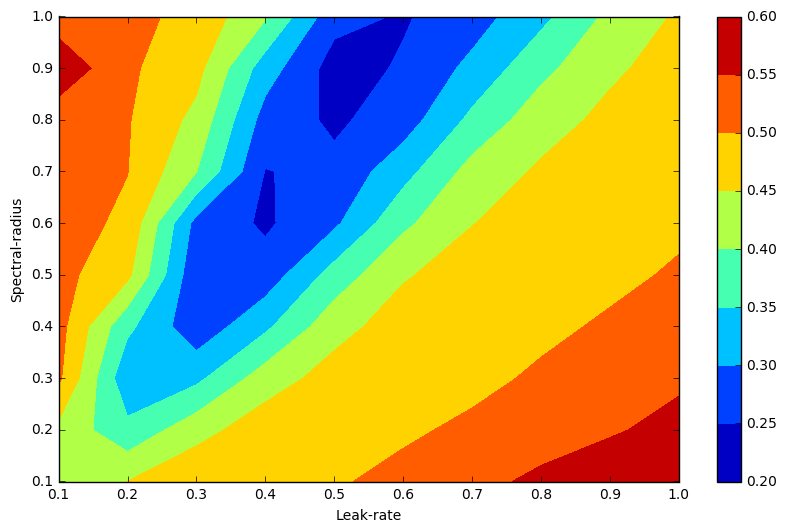

In [4]:
### Errors
import numpy as np
from matplotlib import pyplot
%matplotlib inline
xx, yy = np.meshgrid(l_rate, sp_rad)
pyplot.figure(figsize=(10,6))
pyplot.subplot(111)
pyplot.contourf(xx,
                yy,delta_t_error[0].reshape(10,10).T)
# pyplot.title("Slow and fast trained using the same parameters averaged over 10 trials")
pyplot.xlabel("Leak-rate")
pyplot.ylabel("Spectral-radius")
pyplot.colorbar()